(6강) 본 실습에서는 6강에서 소개하는 다양한 데이터셋을 탐색하고 특징을 분석해낼 수 있도록 하는 코드가 준비되어 있습니다. 캠퍼분들은 아래 EDA 코드를 활용하여 제공되는 학습 데이터셋에 대해 EDA를 수행해 보시길 바랍니다.
아래 OCR 데이터셋에 대해 추가로 선택적으로 데이터 탐색을 수행해 보시길 바랍니다.

- AI Hub 야외 실제 촬영 이미지 등의 외부 데이터셋

## EDA 할 내용
- 이미지 가로, 세로 길이
- 이미지 당 단어 개수 분포
- 전체 태그 별 분포
    - 언어 태그
    - 글자 진행 방향
    - 단어 태그
    - 이미지 태그
- aspect ratio (가로/세로)

original code source : https://www.kaggle.com/aidapearson/eda-starter-notebook

**< Current Package >**
- json==2.0.9
- pandas==2.0.3
- seaborn==0.13.2
- PIL.Image==9.4.0
- numpy==1.23.5
- pathlib==1.0.1
- matplotlib==3.7.5

In [ ]:
# 라이브러리 호출

%matplotlib inline
import glob
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import Image
from collections import Counter
import numpy as np

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
def read_json(filename):
    with Path(filename).open(encoding='utf8') as handle:
        ann = json.load(handle)
    return ann

In [ ]:
# gt file과 raw image file path를 이용해 데이터를 불러온다.
# train.json 파일 경로를 사용하도록 수정 필요.
# colab을 활용할 경우 train.json 파일을 google drive에서 불러오도록 수정 필요.
path_lists = glob.glob(f"./data/*_receipt/ufo/*_train.json")

# 각 json 파일을 읽어서 하나로 합친다.
data = {}
data['images'] = {}
for path in path_lists:
    json_data = read_json(path)
    # 각 파일에서 100개의 이미지 씩만 확인합니다.
    images = list(json_data['images'].items())[:100]
    data['images'].update(dict(images))

print(f"Total number of images: {len(data['images'])}")


Total number of images: 400


In [ ]:
def get_box_size(quads):
    """ 단어 영역의 사각형 좌표가 주어졌을 때 가로, 세로길이를 계산해주는 함수.
    Args:
        quads: np.ndarray(n, 4, 2) n개 단어 bounding-box의 4개 점 좌표 (단위 pixel)
    Return:
        sizes: np.ndarray(n, 2) n개 box의 (height, width)쌍
    """
    dists = []
    for i, j in [(1, 2), (3, 0), (0, 1), (2, 3)]: # [right(height), left(height), upper(width), lower(width)] sides
        dists.append(np.linalg.norm(quads[:, i] - quads[:, j], ord=2, axis=1))

    dists = np.stack(dists, axis=-1).reshape(-1, 2, 2) # shape (n, 2, 2) heights, widths into separate dim
    return np.rint(dists.mean(axis=-1)).astype(int)

In [ ]:
def rectify_poly(poly, direction):
    """일반 polygon형태인 라벨을 크롭하고 rectify한 형태의 가로, 세로 길이를 계산해주는 함수.
    Args:
        poly: np.ndarray(2n+4, 2) (where n>0), 4, 6, 8
        direction: 글자의 읽는 방향과 진행 방향의 수평(Horizontal) 혹은 수직(Vertical) 여부
    Return:
        rectified: np.ndarray(2, ?) rectify된 단어 bbox의 가로, 세로 길이.
    """

    n_pts = poly.shape[0]
    assert n_pts % 2 == 0
    if direction not in ['Horizontal', 'Vertical', 'Irregular']:
        return None
    if n_pts == 4:
        size = get_box_size(poly[None])
        h = size[:, 0]
        w = size[:, 1]
        return np.stack((h,w))

    def unroll(indices):
        return list(zip(indices[:-1], indices[1:]))

    # polygon하나를 인접한 사각형 여러개로 쪼갠다.
    indices = list(range(n_pts))
    if direction == 'Horizontal':
        upper_pts = unroll(indices[:n_pts // 2]) # (0, 1), (1, 2), ... (4, 5)
        lower_pts = unroll(indices[n_pts // 2:])[::-1] # (8, 9), (7, 8), ... (6, 7)

        quads = np.stack([poly[[i, j, k, l]] for (i, j), (k, l) in zip(upper_pts, lower_pts)])
    else:
        right_pts = unroll(indices[1:n_pts // 2 + 1]) # (1, 2), (2, 3), ... (4, 5)
        left_pts = unroll([0] + indices[:n_pts // 2:-1]) # (0, 9), (9, 8), ... (7, 6)

        quads = np.stack([poly[[i, j, k, l]] for (j, k), (i, l) in zip(right_pts, left_pts)])

    sizes = get_box_size(quads)
    if direction in ['Horizontal', 'Irregular']:
        h = sizes[:, 0].max()
        h = np.rint(h).astype(np.int32)
        resize_ratios = h / sizes[:, 0]
        # widths = sizes[:, 1]
        widths = np.rint(sizes[:, 1] * resize_ratios).astype(np.int32)
        w = np.sum(widths)

        return np.vstack((h,w))

    elif direction == 'Vertical':
        w = sizes[:, 1].max()
        w = np.rint(w).astype(np.int32)
        resize_ratios = w / sizes[:, 1]
        heights = np.rint(sizes[:, 0] * resize_ratios).astype(np.int32)
        h = np.sum(heights)
        return np.vstack((h,w))

In [ ]:
# 데이터 구조화: pandas 구조에 맞게 데이터 정렬

df = {}
df['image'] = []
df['word_counts'] = []
df['image_width'] = []
df['image_height'] = []
df['image_tags'] = []
# img_tags = []

quads = []
polys = []
seq_length = []
hor_sizes = []
ver_sizes = []
irr_sizes = []
languages = []
orientation = []
word_height = []
word_width = []
bbox_size = []
word_tags = []
aspect_ratio = []
ver_string = []

for image_key, image_value in list(data["images"].items()):

    df['image'].append(image_key)
    img_w = image_value['img_w']
    img_h = image_value['img_h']
    df['image_width'].append(img_w)
    df['image_height'].append(img_h)
    df['image_tags'].append(image_value['tags'])
    df['image_tags']= [['None'] if v is None else v for v in df['image_tags']]
    word_ann = image_value['words']
    count_ill = 0
    for word in word_ann.values():
        if word['illegibility']== False:
            orientation.append(word['orientation'])
            orientation = [v for v in orientation]
            seq_length.append(len(word['transcription']))
            languages.append(word['language'])
            languages = [['None'] if v is None else v for v in languages]
            if word['tags'] != None:
                word_tags.extend(word['tags'][:])
            elif word['tags']== None:
                word_tags.append('None')
            poly = np.int32(word['points'])
            # print(word['orientation'])
            word_orientation = word['orientation'] if word['orientation'] == 'Vertical' else 'Horizontal'
            size = rectify_poly(poly, word_orientation)
            if word['orientation'] == 'Vertical':
                ver_sizes.append(size)
                bbox_size.append(np.sum(size[0]* size[1]))
            else:
                # print(word['orientation'])
                hor_sizes.append(size)
                bbox_size.append(np.sum(size[0]* size[1]))
        else:
            count_ill += 1
    df['word_counts'].append(len(word_ann)-count_ill)

hor_aspect_ratio = [hor_sizes[i][1]/hor_sizes[i][0] for i in range(len(hor_sizes))]
ver_aspect_ratio = [ver_sizes[i][1]/ver_sizes[i][0] for i in range(len(ver_sizes))]

image_df = pd.DataFrame.from_dict(df)

In [ ]:
image_df

,image,word_counts,image_width,image_height,image_tags
0,extractor.vi.in_house.appen_000001_page0001.jpg,62,1290,1796,[]
1,extractor.vi.in_house.appen_000003_page0001.jpg,86,1024,1332,[]
2,extractor.vi.in_house.appen_000004_page0001.jpg,165,1920,2560,[]
3,extractor.vi.in_house.appen_000005_page0001.jpg,98,1928,2560,[]
4,extractor.vi.in_house.appen_000006_page0001.jpg,142,699,1772,[]
...,...,...,...,...,...
395,extractor.zh.in_house.appen_000066_page0001.jpg,126,1706,1280,[]
396,extractor.zh.in_house.appen_000068_page0001.jpg,136,1080,1920,[]
397,extractor.zh.in_house.appen_000069_page0001.jpg,146,1279,1706,[]
398,extractor.zh.in_house.appen_000070_page0001.jpg,79,779,1130,[]


In [ ]:
image_df['image_tags'] = image_df.image_tags.apply(lambda x: 'None' if len(x) == 0 else x)
image_df

,image,word_counts,image_width,image_height,image_tags
0,extractor.vi.in_house.appen_000001_page0001.jpg,62,1290,1796,None
1,extractor.vi.in_house.appen_000003_page0001.jpg,86,1024,1332,None
2,extractor.vi.in_house.appen_000004_page0001.jpg,165,1920,2560,None
3,extractor.vi.in_house.appen_000005_page0001.jpg,98,1928,2560,None
4,extractor.vi.in_house.appen_000006_page0001.jpg,142,699,1772,None
...,...,...,...,...,...
395,extractor.zh.in_house.appen_000066_page0001.jpg,126,1706,1280,None
396,extractor.zh.in_house.appen_000068_page0001.jpg,136,1080,1920,None
397,extractor.zh.in_house.appen_000069_page0001.jpg,146,1279,1706,None
398,extractor.zh.in_house.appen_000070_page0001.jpg,79,779,1130,None


In [ ]:
image_df.describe()

,word_counts,image_width,image_height
count,400.000000,400.000000,400.000000
mean,86.557500,1446.712500,2395.427500
std,42.321205,782.383627,1133.734156
min,21.000000,268.000000,445.000000
25%,55.000000,952.500000,1333.750000
50%,77.500000,1170.000000,2000.000000
75%,109.000000,1849.250000,3840.500000
max,332.000000,3468.000000,4624.000000


In [ ]:
image_df[['image_width','image_height']].describe()

,image_width,image_height
count,400.000000,400.000000
mean,1446.712500,2395.427500
std,782.383627,1133.734156
min,268.000000,445.000000
25%,952.500000,1333.750000
50%,1170.000000,2000.000000
75%,1849.250000,3840.500000
max,3468.000000,4624.000000


### 이미지의 가로, 세로 길이

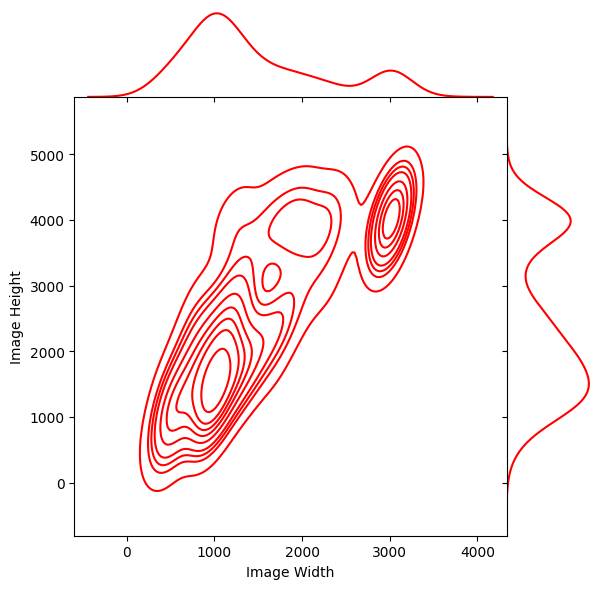

In [ ]:
g = sns.jointplot(x = "image_width", y = "image_height", data=image_df, kind="kde", space=0, color="r")
g.set_axis_labels("Image Width", "Image Height")

### 이미지 태그, 단어 태그

In [ ]:
def create_count_df(df, field, index):
    count=df.groupby(field)[index].count().sort_values(ascending=False)
    count_df = count.to_frame().reset_index()
    count_df.columns = [field, field + '_count']
    return count_df

def plot_count_df(df, field, random_sample, color, rotation, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10,6))
    if random_sample:
        df = df.sample(n=50, random_state=1)
    bars = ax.bar(df[field], df[field + '_count'], color=color, align='center',alpha=0.5)
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
                df.iloc[i][field + '_count'],ha='center',fontsize=13)
    ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()


/tmp/ipykernel_1235845/3362603384.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


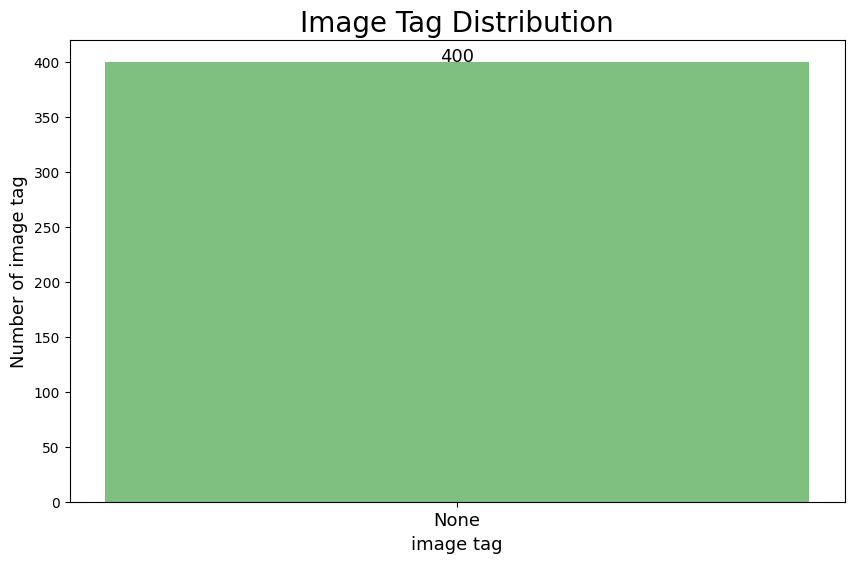

In [ ]:
img_tag_df = create_count_df(df=image_df, field='image_tags', index='image')
plot_count_df(df=img_tag_df, field='image_tags', random_sample=False, color='g', rotation=0, xlabel='image tag', \
              ylabel='Number of image tag', title='Image Tag Distribution')

/tmp/ipykernel_1235845/3362603384.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


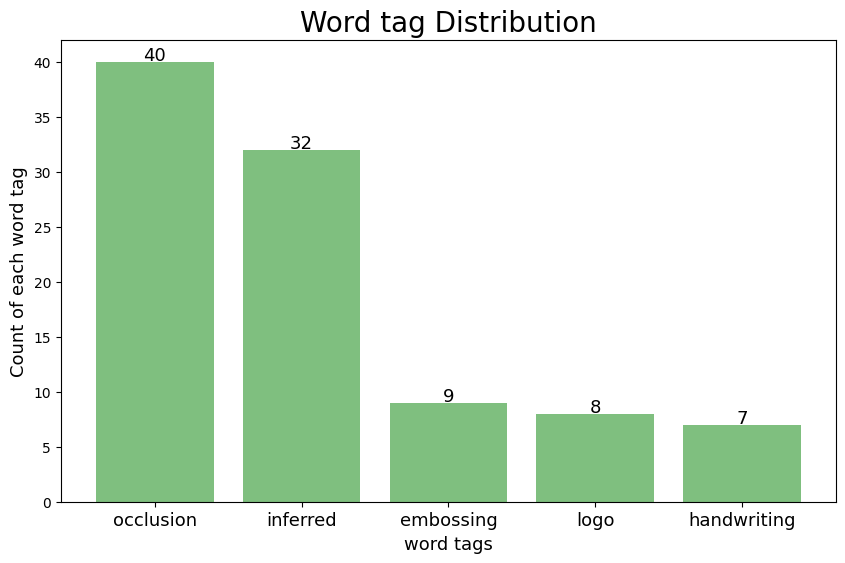

In [ ]:
# Total word tags
word_tags = [i for i in word_tags if i not in ['Auto','UpdatedBbox','UpdatedText','UpdatedTags']]
word_tag_df = pd.DataFrame(word_tags, columns = ['tags'])
word_tag_df['index'] = [i for i in range(len(word_tags))]
word_tag_df = create_count_df(word_tag_df, field='tags',index='index')
plot_count_df(df=word_tag_df, field='tags', random_sample=False, color='g', rotation=0, xlabel='word tags', \
              ylabel='Count of each word tag', title='Word tag Distribution')

### 단어 당 이미지 수

In [ ]:
def plot_dist(df, field, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(df[field], bins=bins, color=color, ax=ax)

    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

/tmp/ipykernel_1235845/3776590594.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[field], bins=bins, color=color, ax=ax)


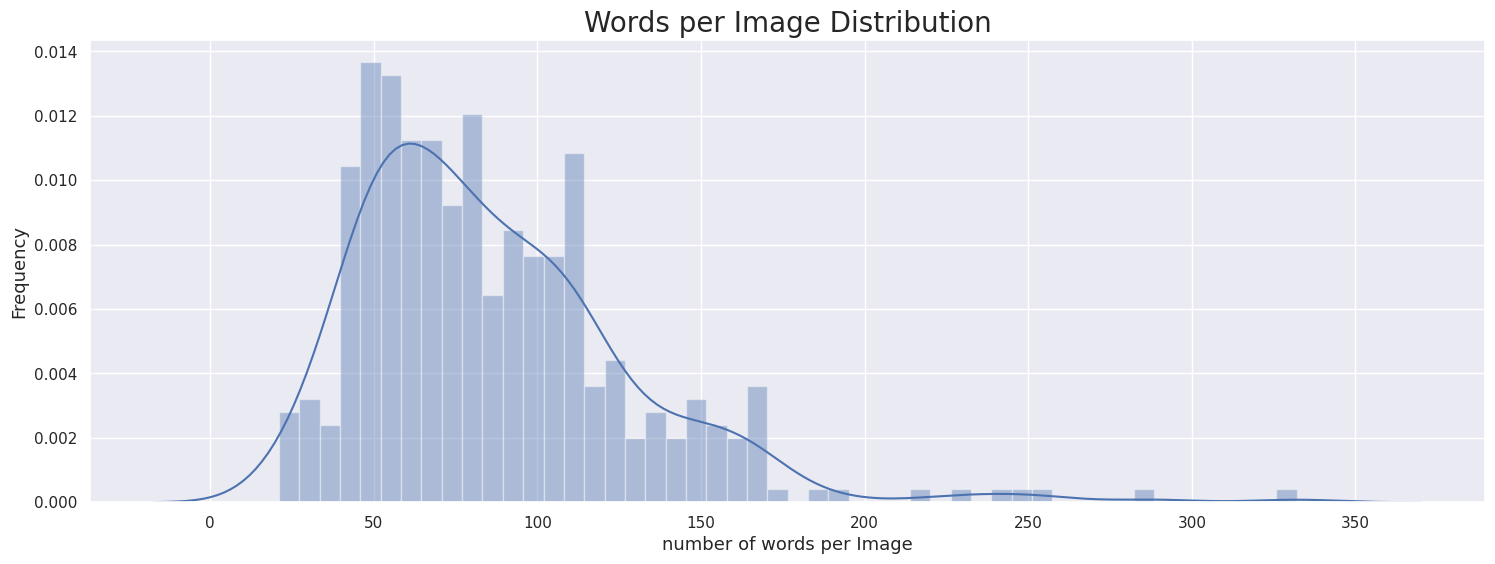

In [ ]:
plot_dist(df=image_df, field='word_counts', bins=50, color='b', xlabel='number of words per Image', \
          ylabel='Frequency', title='Words per Image Distribution')

In [ ]:
word_df ={}
word_df['index'] = [i for i in range(len(bbox_size))]
word_df['orientation'] = orientation
word_df['language'] = languages
# word_df['height'] = word_height
# word_df['width'] = word_width
word_df['bbox_size'] = bbox_size

In [ ]:
word_df = pd.DataFrame.from_dict(word_df)
word_df

,index,orientation,language,bbox_size
0,0,,"[numeric, english]",12892
1,1,,[english],3440
2,2,,"[diacritic, english, symbol]",6536
3,3,,"[diacritic, english]",5408
4,4,,"[diacritic, english, symbol]",6534
...,...,...,...,...
34618,34618,,"[korean, taiwanese, symbol, chinese, japanese]",4690
34619,34619,,"[korean, japanese, taiwanese, chinese]",4788
34620,34620,,"[korean, taiwanese, symbol, chinese, japanese]",6300
34621,34621,,"[symbol, numeric]",7474


In [ ]:
# 언어 태그를 plot 상에 간단히 나타내기 위해 전체 언어태그를 확인하고, mapping table을 만든다.
language_list = word_df['language'].tolist()
# flatten list
language_list = [item for sublist in language_list for item in sublist]
set(language_list)

{'None',
 'chinese',
 'circled',
 'cyrillic',
 'diacritic',
 'english',
 'greek',
 'japanese',
 'korean',
 'numeric',
 'symbol',
 'taiwanese'}

In [ ]:
lang_map = {'chinese':'zh','japanese':'ja', 'korean':'ko', 'english':'en','symbol':'sym','numeric':'num','taiwanese':'zh-tw','diacritic':'diac','circled':'circ'}
word_df['language'] = word_df['language'].apply(lambda x: [lang_map[i] if i in lang_map.keys() else i for i in x])
word_df['language'] = word_df['language'].apply(lambda x: list(set(x)))
word_df

,index,orientation,language,bbox_size
0,0,,"[num, en]",12892
1,1,,[en],3440
2,2,,"[sym, diac, en]",6536
3,3,,"[diac, en]",5408
4,4,,"[sym, diac, en]",6534
...,...,...,...,...
34618,34618,,"[ja, zh-tw, zh, sym, ko]",4690
34619,34619,,"[zh-tw, zh, ja, ko]",4788
34620,34620,,"[ja, zh-tw, zh, sym, ko]",6300
34621,34621,,"[sym, num]",7474


In [ ]:
word_df['orientation'] = word_df['orientation'].apply(lambda x: 'Horizontal' if x == '' else x)

In [ ]:
word_df['language'] = word_df['language'].apply(lambda x: ','.join(map(str, x)))
word_df

,index,orientation,language,bbox_size
0,0,,"num,en",12892
1,1,,en,3440
2,2,,"sym,diac,en",6536
3,3,,"diac,en",5408
4,4,,"sym,diac,en",6534
...,...,...,...,...
34618,34618,,"ja,zh-tw,zh,sym,ko",4690
34619,34619,,"zh-tw,zh,ja,ko",4788
34620,34620,,"ja,zh-tw,zh,sym,ko",6300
34621,34621,,"sym,num",7474


### 언어 태그가 의미하는 바를 확인하기 위해 이미지를 확인합니다.

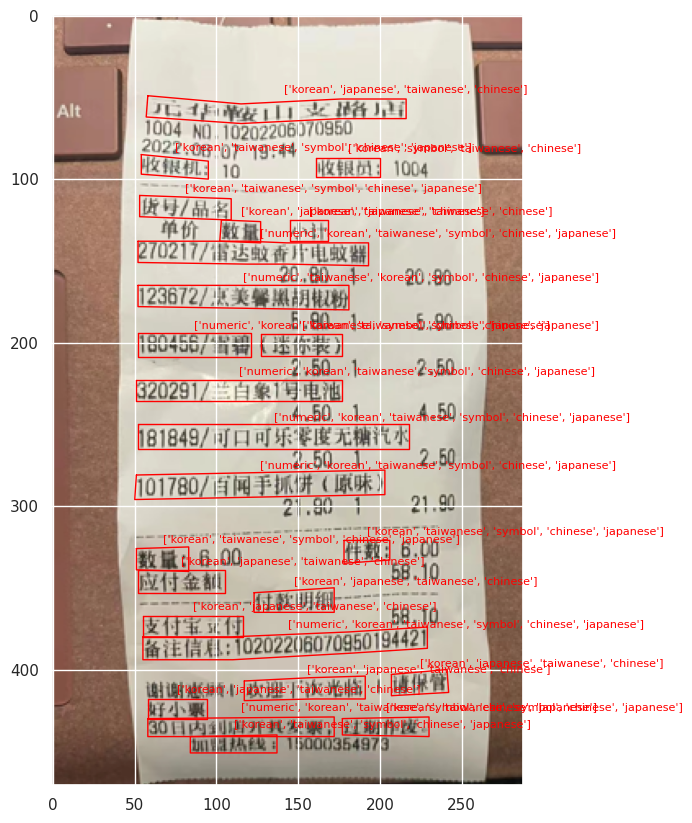

In [ ]:
# 이미지 내부의 bbox를 확인합니다.
def plot_bbox_language(image_key, lang, num_lang):
    image = Image.open(f'./data/{lang}_receipt/img/train/{image_key}')
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(image)
    word_ann = data["images"][image_key]['words']
    for word in word_ann.values():
        if word['illegibility']== False:
            if word['language'] != None and len(word['language'])> num_lang:
                poly = np.int32(word['points'])
                poly = poly.reshape(-1, 2)
                ax.plot(np.append(poly[:, 0], poly[0, 0]), np.append(poly[:, 1], poly[0, 1]), color='red', linewidth=1)
                poly_center = np.mean(poly, axis=0)
                ax.text(poly_center[0], poly_center[1] - 10, word['language'], fontsize=8, color='red')
    plt.show()

plot_bbox_language('extractor.zh.in_house.appen2_001021_page0001.jpg', 'chinese',3)

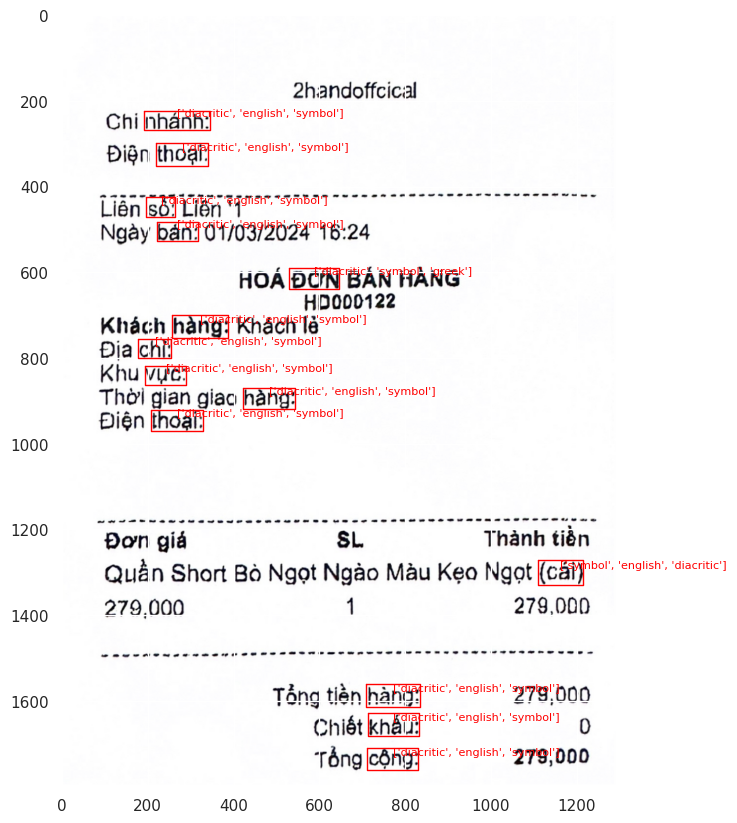

In [ ]:
plot_bbox_language('extractor.vi.in_house.appen_000001_page0001.jpg', 'vietnamese',2)

### 글자 진행 방향

/tmp/ipykernel_318306/3362603384.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


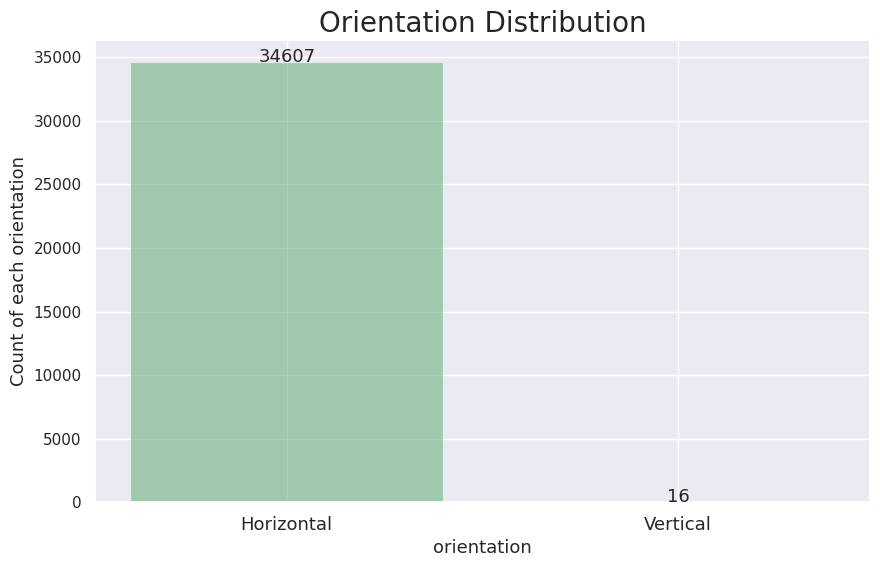

In [ ]:
orientation = create_count_df(df=word_df, field='orientation', index='index')
plot_count_df(df=orientation, field='orientation', random_sample=False, color='g', rotation=0, xlabel='orientation', \
              ylabel='Count of each orientation', title='Orientation Distribution')

### 언어

/tmp/ipykernel_1235845/3362603384.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


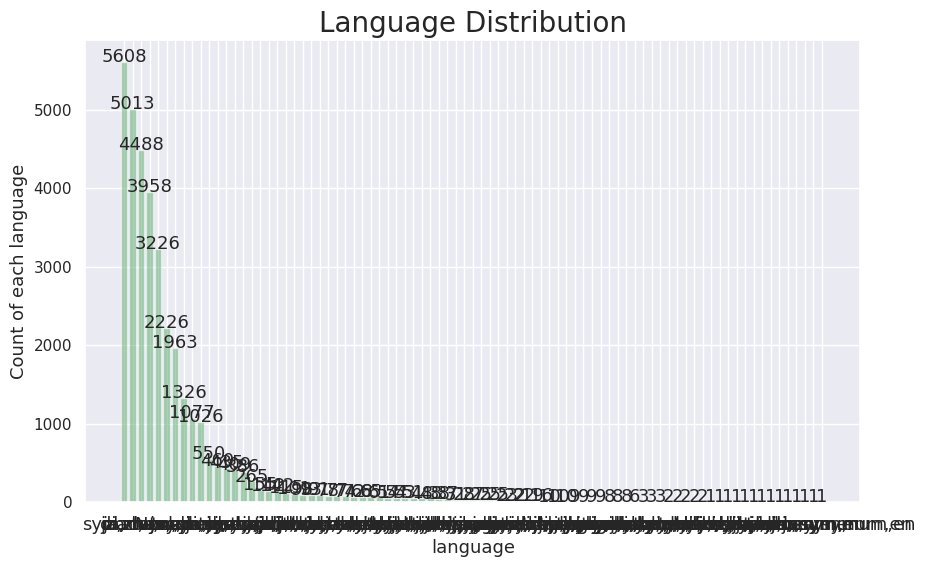

In [ ]:
lang = create_count_df(df=word_df, field='language', index='index')
plot_count_df(df=lang, field='language', random_sample=False, color='g', rotation=0, xlabel='language', \
              ylabel='Count of each language', title='Language Distribution')

In [ ]:
# 가장 상위 10개의 언어 라벨 결과를 살펴본다
def plot_count_df_top10(df, field, random_sample, color, rotation, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10,6))
    if random_sample:
        df = df.sample(n=50, random_state=1)
    df = df.nlargest(10, field + '_count')  # Select top 10 frequent labels
    bars = ax.bar(df[field], df[field + '_count'], color=color, align='center',alpha=0.5)
    for i, b in enumerate(bars):
        ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
                df.iloc[i][field + '_count'],ha='center',fontsize=13)
    ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

/tmp/ipykernel_1235845/4073356657.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[field],rotation=rotation, fontsize=13)


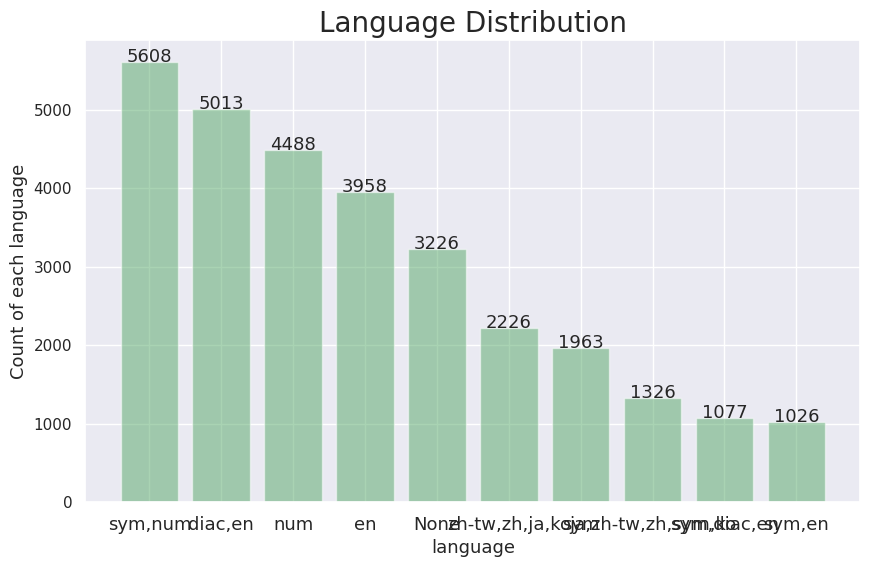

In [ ]:
# None은 다른 언어나 특수 기호를 의미
lang = create_count_df(df=word_df, field='language', index='index')
plot_count_df_top10(df=lang, field='language', random_sample=False, color='g', rotation=0, xlabel='language', \
              ylabel='Count of each language', title='Language Distribution')

### Aspect Ratio

In [ ]:
def plot_dist_list(target_list, bins, color, xlabel, ylabel, title):
    sns.set(color_codes=True)
    fig, ax = plt.subplots(figsize=(18,6))
    sns.distplot(target_list, bins=bins, color=color, ax=ax)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_title(title, fontsize=20)
    plt.show()

/tmp/ipykernel_1235845/1739589287.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_list, bins=bins, color=color, ax=ax)


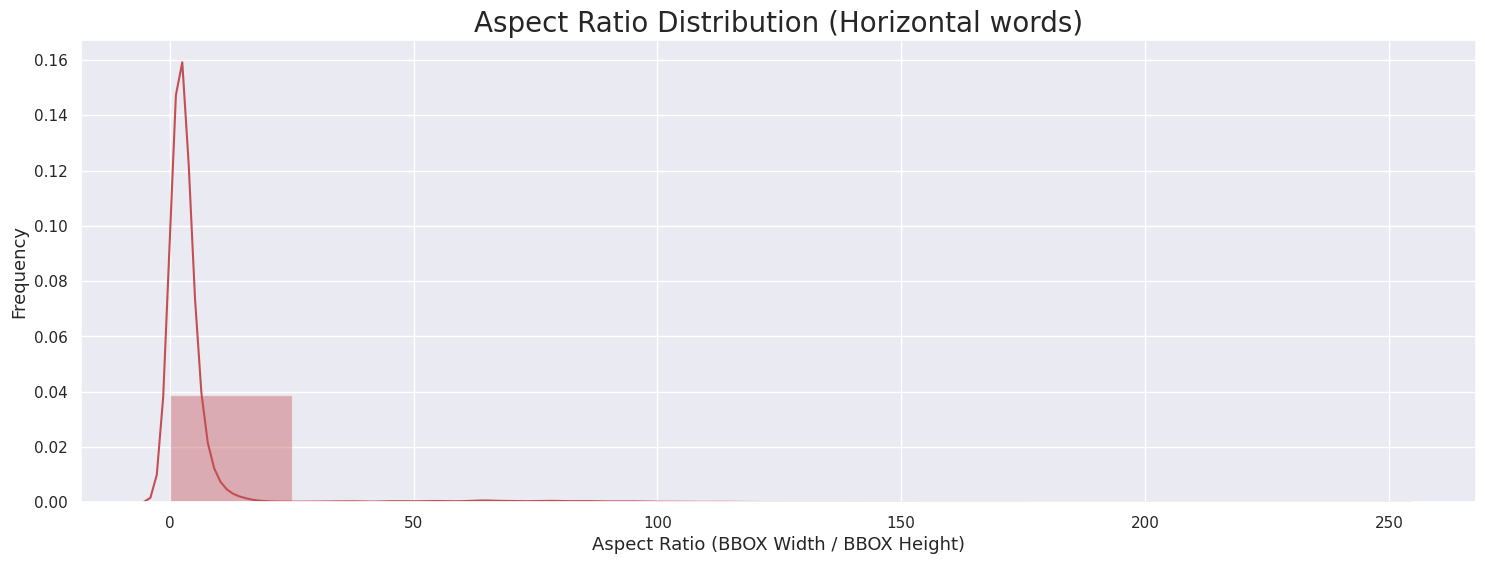

In [ ]:
# horizontal 단어들의 aspect ratio
# 한 두글자짜리 단어나 숫자의 경우 aspect ratio가 1미만인 경우가 있다
plot_dist_list(hor_aspect_ratio, bins=10, color='r', xlabel='Aspect Ratio (BBOX Width / BBOX Height)', \
          ylabel='Frequency', title='Aspect Ratio Distribution (Horizontal words)')

/tmp/ipykernel_1235845/1739589287.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(target_list, bins=bins, color=color, ax=ax)


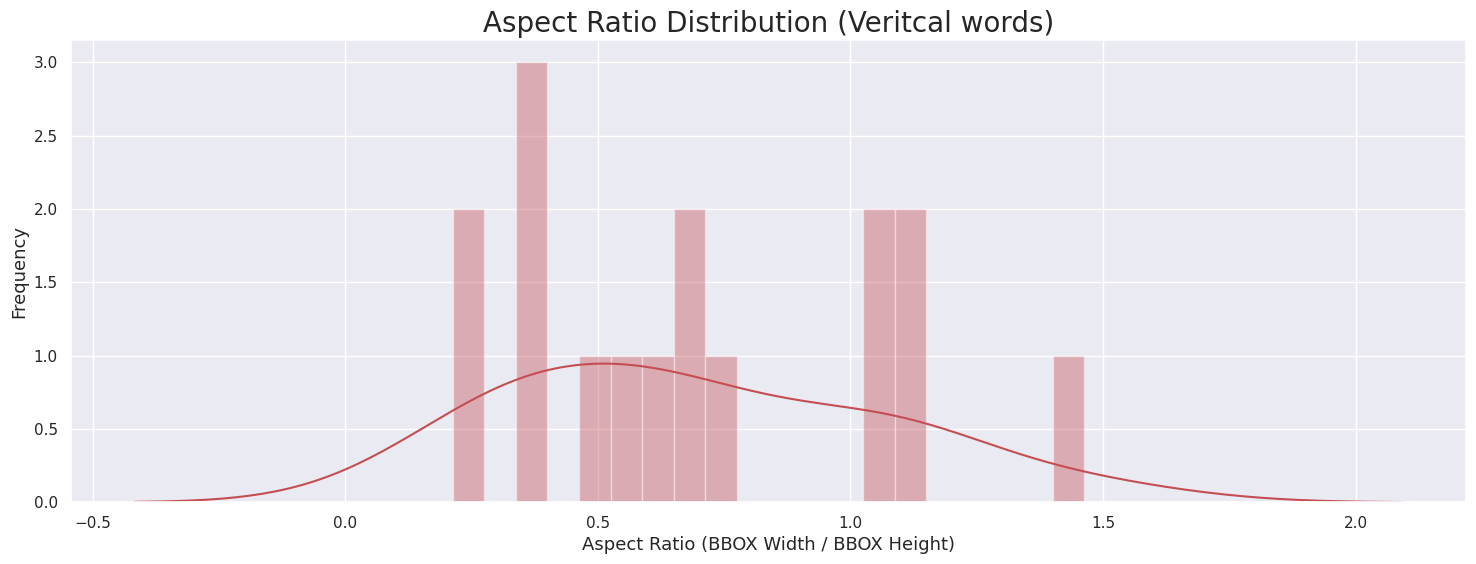

In [ ]:
# 세로 방향 단어들의 aspect ration
plot_dist_list(ver_aspect_ratio, bins=20, color='r', xlabel='Aspect Ratio (BBOX Width / BBOX Height)', \
          ylabel='Frequency', title='Aspect Ratio Distribution (Veritcal words)')

### BBOX 크기

In [ ]:
word_df['bbox_size'].describe()

count    3.462300e+04
mean     8.694606e+03
std      2.079535e+04
min      8.000000e+00
25%      1.012000e+03
50%      2.800000e+03
75%      8.746500e+03
max      1.461429e+06
Name: bbox_size, dtype: float64

/tmp/ipykernel_318306/3776590594.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[field], bins=bins, color=color, ax=ax)


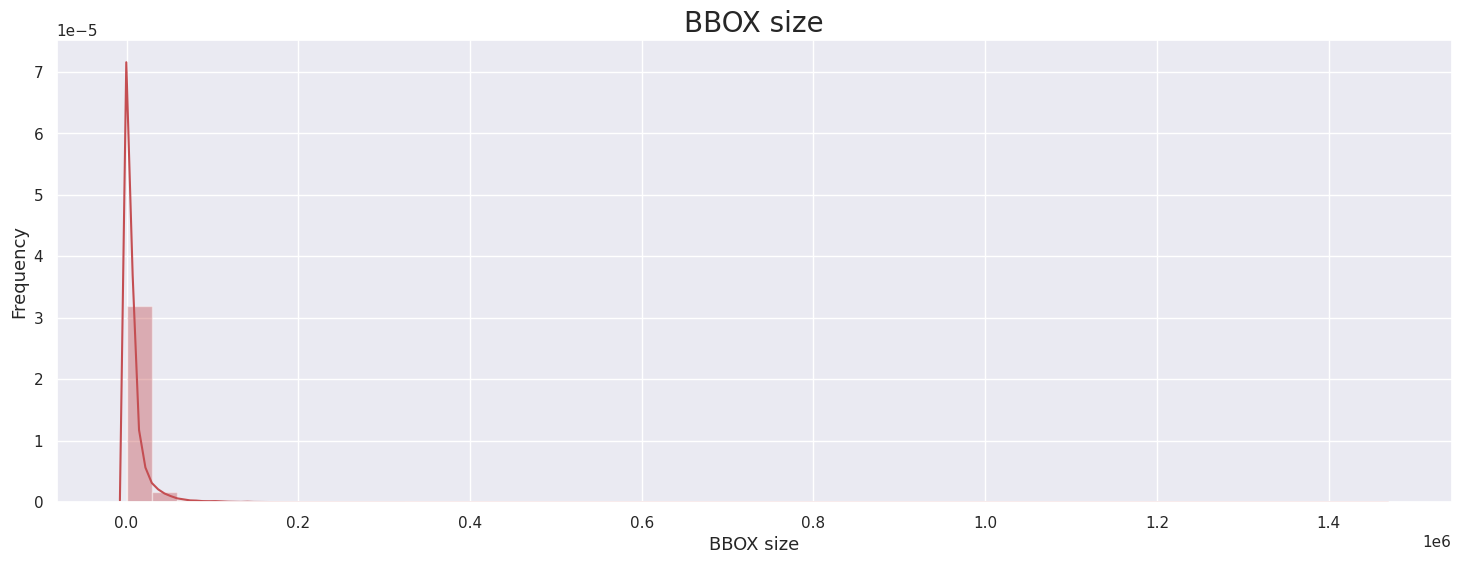

In [ ]:
# bbox size 분포
plot_dist(df=word_df, field='bbox_size', bins=50, color='r', xlabel='BBOX size', \
          ylabel='Frequency', title='BBOX size')

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

